<a href="https://colab.research.google.com/github/seyonechithrananda/deepchem/blob/chemberta-tutorial/23_Transfer_Learning_With_ChemBERTa_Transformers_Pt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 22, ChemBERTa: Large-Scale Self-Supervised Pretraining for Molecular Property Prediction (Part 2 of ChemBERTa series)

## Using the Smiles-Tokenizer class in DeepChem with ChemBERTa for attention visualization and fine-tuning.

![alt text](https://huggingface.co/front/assets/huggingface_mask.svg)

By Seyone Chithrananda ([Twitter](https://twitter.com/SeyoneC))

Deep learning for chemistry and materials science remains a novel field with lots of potiential. However, the popularity of transfer learning based methods in areas such as NLP and computer vision have not yet been effectively developed in computational chemistry + machine learning. In the last tutorial, we utilized a ChemBERTa model which was pre-trained on 10,000,000 SMILES strings. Our default tokenization strategy uses a Byte-Pair Encoder (BPE) from the HuggingFace tokenizers library. Using HuggingFace's suite of models and the BPE tokenizer, we are able to train a large-transformer model, RoBERTa, on a large corpus of 10,000,000 SMILES strings from a commonly known benchmark chemistry dataset, PubChem.

Training RoBERTa over 10 epochs, the model achieves a pretty good loss of 0.198, and may likely continue to converge if trained for a larger number of epochs. The model can predict masked/corrupted tokens within a SMILES sequence/molecule, allowing for variants of a molecule within discoverable chemical space to be predicted.


BPE is a hybrid between character and word-level representations, which allows for the handling of large vocabularies in natural language corpora. Motivated by the intuition that rare and unknown words can often be decomposed into multiple known subwords, BPE finds the best word segmentation by iteratively and greedily merging frequent pairs of characters. In our work, we compared this
tokenization algorithm with a **custom SmilesTokenizer** based on a regex pattern, which we have released as part of DeepChem. To compare tokenizers, we pretrained an identical model tokenized using this novel tokenizer, on the PubChem-1M set. The pretrained model was evaluated on the Tox21 SR-p53 task in the paper. We found that the SmilesTokenizer narrowly outperformed the BPE algorithm by ∆PRC-AUC = +0.015. Though this result suggests that a more semantically relevant tokenization may provide performance benefits, further benchmarking on additional datasets is needed to validate this finding. **In this tutorial, we aim to do so, by testing this alternate model on the ClinTox dataset, attention visualization tasks, and maskesd token inference.**

By applying the representations of functional groups and atoms learned by the model, we can try to tackle problems of toxicity, solubility, drug-likeness, and synthesis accessibility on smaller datasets using the learned representations as features for graph convolution and attention models on the graph structure of molecules, as well as fine-tuning of BERT. Finally, we propose the use of attention visualization as a helpful tool for chemistry practitioners and students to quickly identify important substructures in various chemical properties.

Additionally, visualization of the attention mechanism have been seen through previous research as incredibly valuable towards chemical reaction classification. The applications of open-sourcing large-scale transformer models such as RoBERTa with HuggingFace may allow for the acceleration of these individual research directions.

A link to a repository which includes the training, uploading and evaluation notebook (with sample predictions on compounds such as Remdesivir) can be found [here](https://github.com/seyonechithrananda/bert-loves-chemistry). All of the notebooks can be copied into a new Colab runtime for easy execution. This repository will be updated with new features, such as attention visualization, easier benchmarking infrastructure, and more. The work behind this tutorial has been published on [Arxiv](https://arxiv.org/abs/2010.09885), and has been accepted for a highlight presentation at NeurIPS 2020's ML for Molecules Workshop, where we will highlight updates to this work.

For the sake of this tutorial, we'll be fine-tuning a pre-trained ChemBERTa on a small-scale molecule dataset, Clintox, to show the potiential and effectiveness of HuggingFace's NLP-based transfer learning applied to computational chemistry. Output for some cells are purposely cleared for readability, so do not worry if some output messages for your cells differ!

Installing DeepChem from source, alongside RDKit for molecule visualizations

In [1]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install --pre deepchem
import deepchem
deepchem.__version__

from rdkit import Chem


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0  17989      0 --:--:-- --:--:-- --:--:-- 17989


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
all packages are already installed


# conda environments:
#
base                  *  /root/miniconda



wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


We want to install NVIDIA's Apex tool, for the training pipeline used by `simple-transformers` and Weights and Biases. In order to support SmilesTokenizer, we have to install a fork of the `simple-transformers` library

In [ ]:
!git clone https://github.com/NVIDIA/apex
!cd /content/apex
!pip install -v --no-cache-dir /content/apex
!pip install transformers
!pip install git+https://github.com/seyonechithrananda/simpletransformers.git@pip
!pip install wandb
!cd ..

We're going to clone an auxillary repository, bert-loves-chemistry, which will enable us to use the MolNet dataloader for ChemBERTa, which automatically generates scaffold splits on any MoleculeNet dataset!

In [9]:
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

Cloning into 'bert-loves-chemistry'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 269 (delta 26), reused 80 (delta 13), pack-reused 167
Receiving objects: 100% (269/269), 44.67 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [10]:
!nvidia-smi

Sun Nov 22 06:41:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now, to ensure our the SmilesTokenizer-ChemBERTa model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for benzene.

In [3]:
# Test if NVIDIA apex training tool works
from apex import amp

Let's fetch the Smiles Tokenizer's character per line vocabulary file, which can bve loaded from the DeepChem S3 data bucket

In [12]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt

--2020-11-22 06:41:55--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.116.113
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.116.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3524 (3.4K) [text/plain]
Saving to: ‘vocab.txt.1’

vocab.txt.1         100%[===================>]   3.44K  --.-KB/s    in 0s      

2020-11-22 06:41:55 (209 MB/s) - ‘vocab.txt.1’ saved [3524/3524]



In [15]:
%cd /content/bert-loves-chemistry/bertviz_clone

/content/bert-loves-chemistry/bertviz_clone


In [16]:
from transformers import AutoModelWithLMHead, AutoTokenizer, pipeline, RobertaModel
from bertviz import head_view
from deepchem.feat.smiles_tokenizer import SmilesTokenizer


model = AutoModelWithLMHead.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:837: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [17]:
smiles_mask = "C1=CC=CC<mask>C1"
smiles = "C1=CC=CC=C1"

masked_smi = fill_mask(smiles_mask)

for smi in masked_smi:
  print(smi)

{'sequence': '<s>C1=CC=CC=C1</s>', 'score': 0.9755934476852417, 'token': 33, 'token_str': '='}
{'sequence': '<s>C1=CC=CC#C1</s>', 'score': 0.020923877134919167, 'token': 7, 'token_str': '#'}
{'sequence': '<s>C1=CC=CC1C1</s>', 'score': 0.0007658973336219788, 'token': 21, 'token_str': '1'}
{'sequence': '<s>C1=CC=CC2C1</s>', 'score': 0.000412977795349434, 'token': 22, 'token_str': '2'}
{'sequence': '<s>C1=CC=CC=[C1</s>', 'score': 0.00025319133419543505, 'token': 352, 'token_str': '=['}


Here, we get some interesting results. The final branch, `C1=CC=CC=C1`, is a  benzene ring. Since its a pretty common molecule, the model is easily able to predict the final double carbon bond with a score of 0.98. Let's get a list of the top 5 predictions (including the target, Remdesivir), and visualize them (with a highlighted focus on the beginning of the final benzene-like pattern).


In [18]:
import torch
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage
from PIL import Image


def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol


def find_matches_one(mol,submol):
    #find all matching atoms for each submol in submol_list in mol.
    match_dict = {}
    mols = [mol,submol] #pairwise search
    res=rdFMCS.FindMCS(mols) #,ringMatchesRingOnly=True)
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches

#Draw the molecule
def get_image(mol,atomset):    
    hcolor = colors.to_rgb('green')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img

In [19]:
sequence = f"C1=CC=CC={tokenizer.mask_token}1"
substructure = "CC=CC"
image_list = []

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

token_logits = model(input)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
  smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
  print (smi)
  smi_mol = get_mol(smi)
  substructure_mol = get_mol(substructure)
  if smi_mol is None: # if the model's token prediction isn't chemically feasible
    continue
  Draw.MolToFile(smi_mol, smi+".png")
  matches = find_matches_one(smi_mol, substructure_mol)
  atomset = list(matches[0])
  img = get_image(smi_mol, atomset)
  img.format="PNG" 
  image_list.append(img)

C1=CC=CC=CC1
C1=CC=CC=CCC1
C1=CC=CC=CN1
C1=CC=CC=CCCC1
C1=CC=CC=CCO1


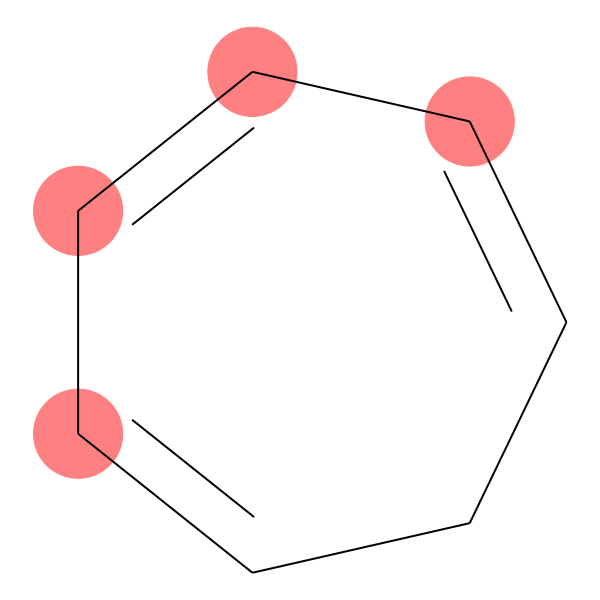

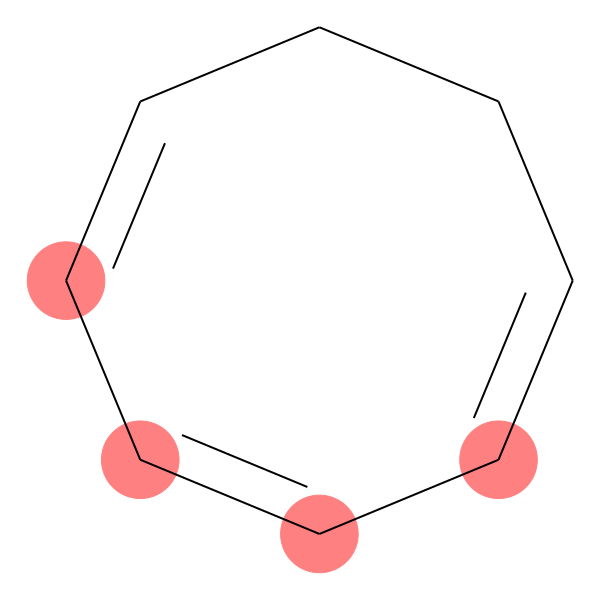

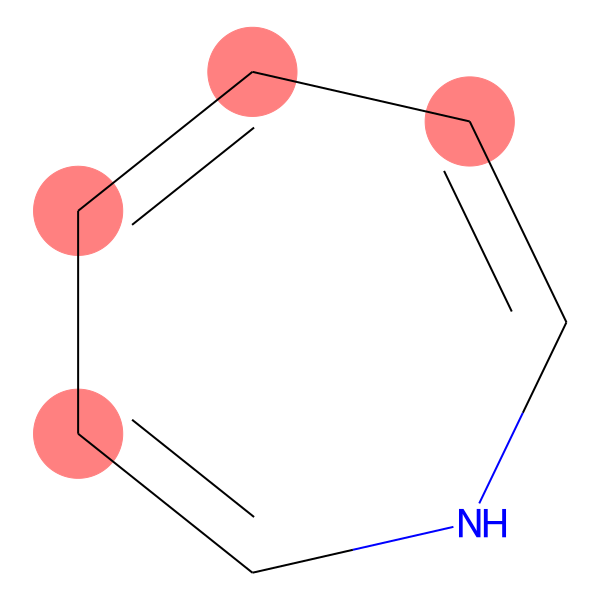

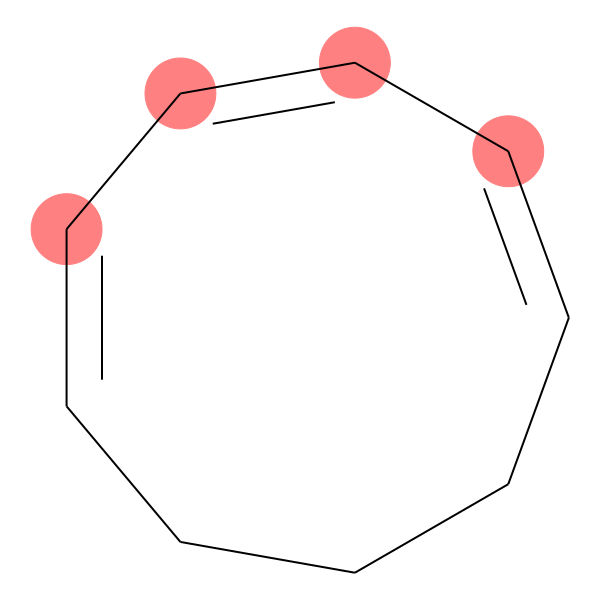

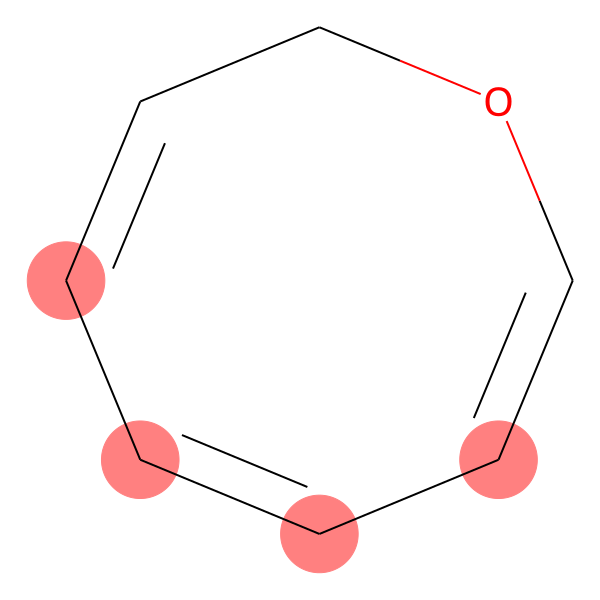

In [20]:
from IPython.display import Image 

for img in image_list:
  display(img)

As we can see above, 5 out of 5 of the model's MLM predictions are chemically valid. Overall, the model seems to understand syntax with a pretty decent degree of certainity. 

However, further training on a more specific dataset (say leads for a specific target) may generate a stronger chemical transformer model. Let's now fine-tune our model on a dataset of our choice, ClinTox. You can run ChemBERTa on any MoleculeNet dataset, but for the sake of convinience, we will use ClinTox as it is small and trains quickly.

# Visualizing the Attention Mechanism in ChemBERTa using BertViz

[BertViz](https://github.com/jessevig/bertviz) is a tool for visualizing attention in the Transformer model, supporting all models from the transformers library (BERT, GPT-2, XLNet, RoBERTa, XLM, CTRL, etc.). It extends the Tensor2Tensor visualization tool by Llion Jones and the transformers library from HuggingFace.

Using this tool, we can easily plug in ChemBERTa with the Smiles Tokenizer from the HuggingFace model hub and visualize the attention patterns produced by one or more attention heads in a given transformer layer. This is known as the attention-head view.

Lets start by obtaining a Javascript object for d3.js and jquery to create interactive visualizations:


In [21]:
from transformers import RobertaModel, RobertaTokenizer
from bertviz import head_view

In [22]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

Now, we create an instance of ChemBERTa, tokenize a set of SMILES strings, and compute the attention for each head in the transformer. There are over a dozen different ChemBERTa models hosted by DeepCHem on HuggingFace's model hub, which use different tokenizers and string representations. You can plug and play whichever model you want for the following demo, as long as you load the right tokenizer! 





In the following example, we take two SMILES molecules from the ZINC database with nearly identical chemical structure, the only difference being rooted in chiral specification (hence the additional `‘@‘` symbol). This is a feature of molecules which indicates that there exists tetrahedral centres. `‘@'` tells us whether the neighbours of a molecule appear in a counter-clockwise order, whereas `‘@@‘` indicates that the neighbours are ordered in a clockwise direction. The model should ideally refer to similar substructures in each SMILES string with a higher attention weightage. 

Lets look at the first SMILES string: `CCCCC[C@@H](Br)CC`:



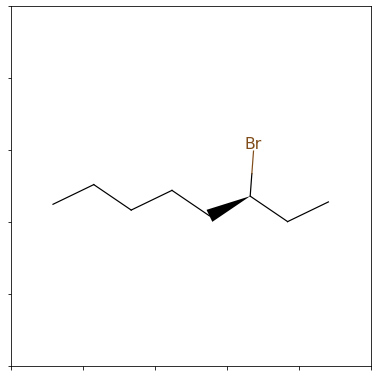

In [23]:
m = Chem.MolFromSmiles('CCCCC[C@@H](Br)CC')
fig = Draw.MolToMPL(m, size=(200, 200))

And the second SMILES string, `CCCCC[C@H](Br)CC`:


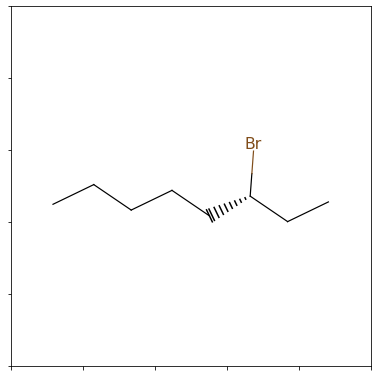

In [24]:
m = Chem.MolFromSmiles('CCCCC[C@H](Br)CC')
fig = Draw.MolToMPL(m, size=(200,200))

The visualization below shows the attention induced by a sample input SMILES. This view visualizes attention as lines connecting the tokens being updated (left) with the tokens being attended to (right), following the design of the figures above. Color intensity reflects the attention weight; weights close to one show as very dark lines, while weights close to zero appear as faint lines or are not visible at all. The user may highlight a particular SMILES character to see the attention from that token only. This visualization is called the attention-head view. It is based on the excellent Tensor2Tensor visualization tool, and are all generated by the [Bertviz](https://github.com/jessevig/bertviz) library.

Here, we will be contrasting the previous tutorial by using the `SmilesTokenizer-ChemBERTa model`, which was trained on 1M SMILES strings from the PubChem dataset, and tokenized using a regex pattern from the Smiles Tokenizer. What makes this tokenizer different is each token represents an atom symbol, meaning the tokens will be far more chemically correct in terms of syntax and semantics.

Let's load the [Smiles-Tokenizer](https://deepchem.readthedocs.io/en/latest/api_reference/tokenizers.html) model from HuggingFace's model hub, which was pre-trained on 1M SMILES sequences from PubChem.



In [25]:
from transformers import BertTokenizer, BertModel

model_version = 'seyonec/SMILES_tokenized_PubChem_shard00_160k'
do_lower_case = False
model = RobertaModel.from_pretrained(model_version, output_attentions=True)
tokenizer = SmilesTokenizer('/content/vocab.txt', max_len=model.config.max_position_embeddings)
print(tokenizer.encode("CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1"))


sentence_a = "CCCCC[C@@H](Br)CC"
sentence_b = "CCCCC[C@H](Br)CC"

inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
head_view(attention, tokens)


#show_head_view(model, tokenizer, sentence_a, sentence_b)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1423: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


[12, 16, 16, 16, 17, 16, 16, 18, 16, 19, 16, 17, 22, 19, 18, 33, 17, 16, 18, 23, 181, 17, 22, 19, 18, 17, 19, 16, 33, 20, 19, 55, 17, 16, 23, 18, 17, 33, 17, 19, 18, 35, 20, 19, 18, 16, 20, 22, 16, 16, 22, 16, 21, 23, 20, 23, 22, 16, 23, 22, 16, 21, 23, 18, 19, 16, 20, 22, 16, 16, 22, 16, 16, 22, 16, 20, 13]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Smiles-Tokenizer Attention by Head View
![alt text](https://media.giphy.com/media/zpfTwb3Og65ifEWymt/giphy.gif)

The visualization shows that attention is highest between words that don’t cross a boundary between the two SMILES strings; the model seems to understand that it should relate tokens to other tokens in the same molecule in order to best understand their context.

There are many other fascinating visualizations we can do, such as a neuron-by neuron analysis of attention or a model overview that visualizes all of the heads at once:

# Attention by Head View:
![alt text](https://media.giphy.com/media/cLGrM5gfbqj63k2bU2/giphy.gif)
# Model View:
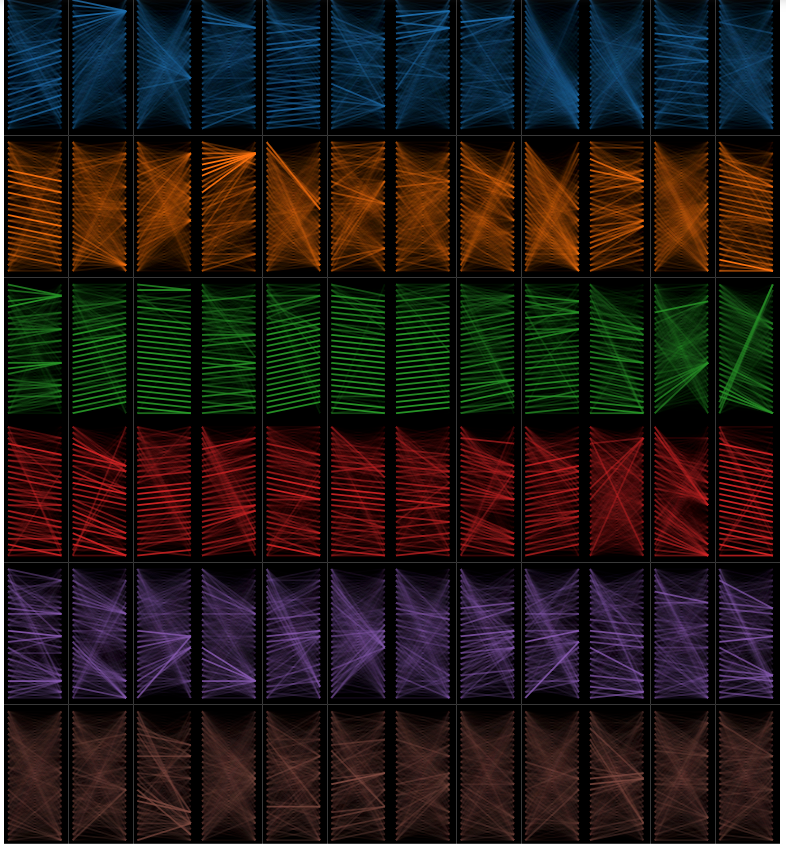

# Neuron-by-neuron view:




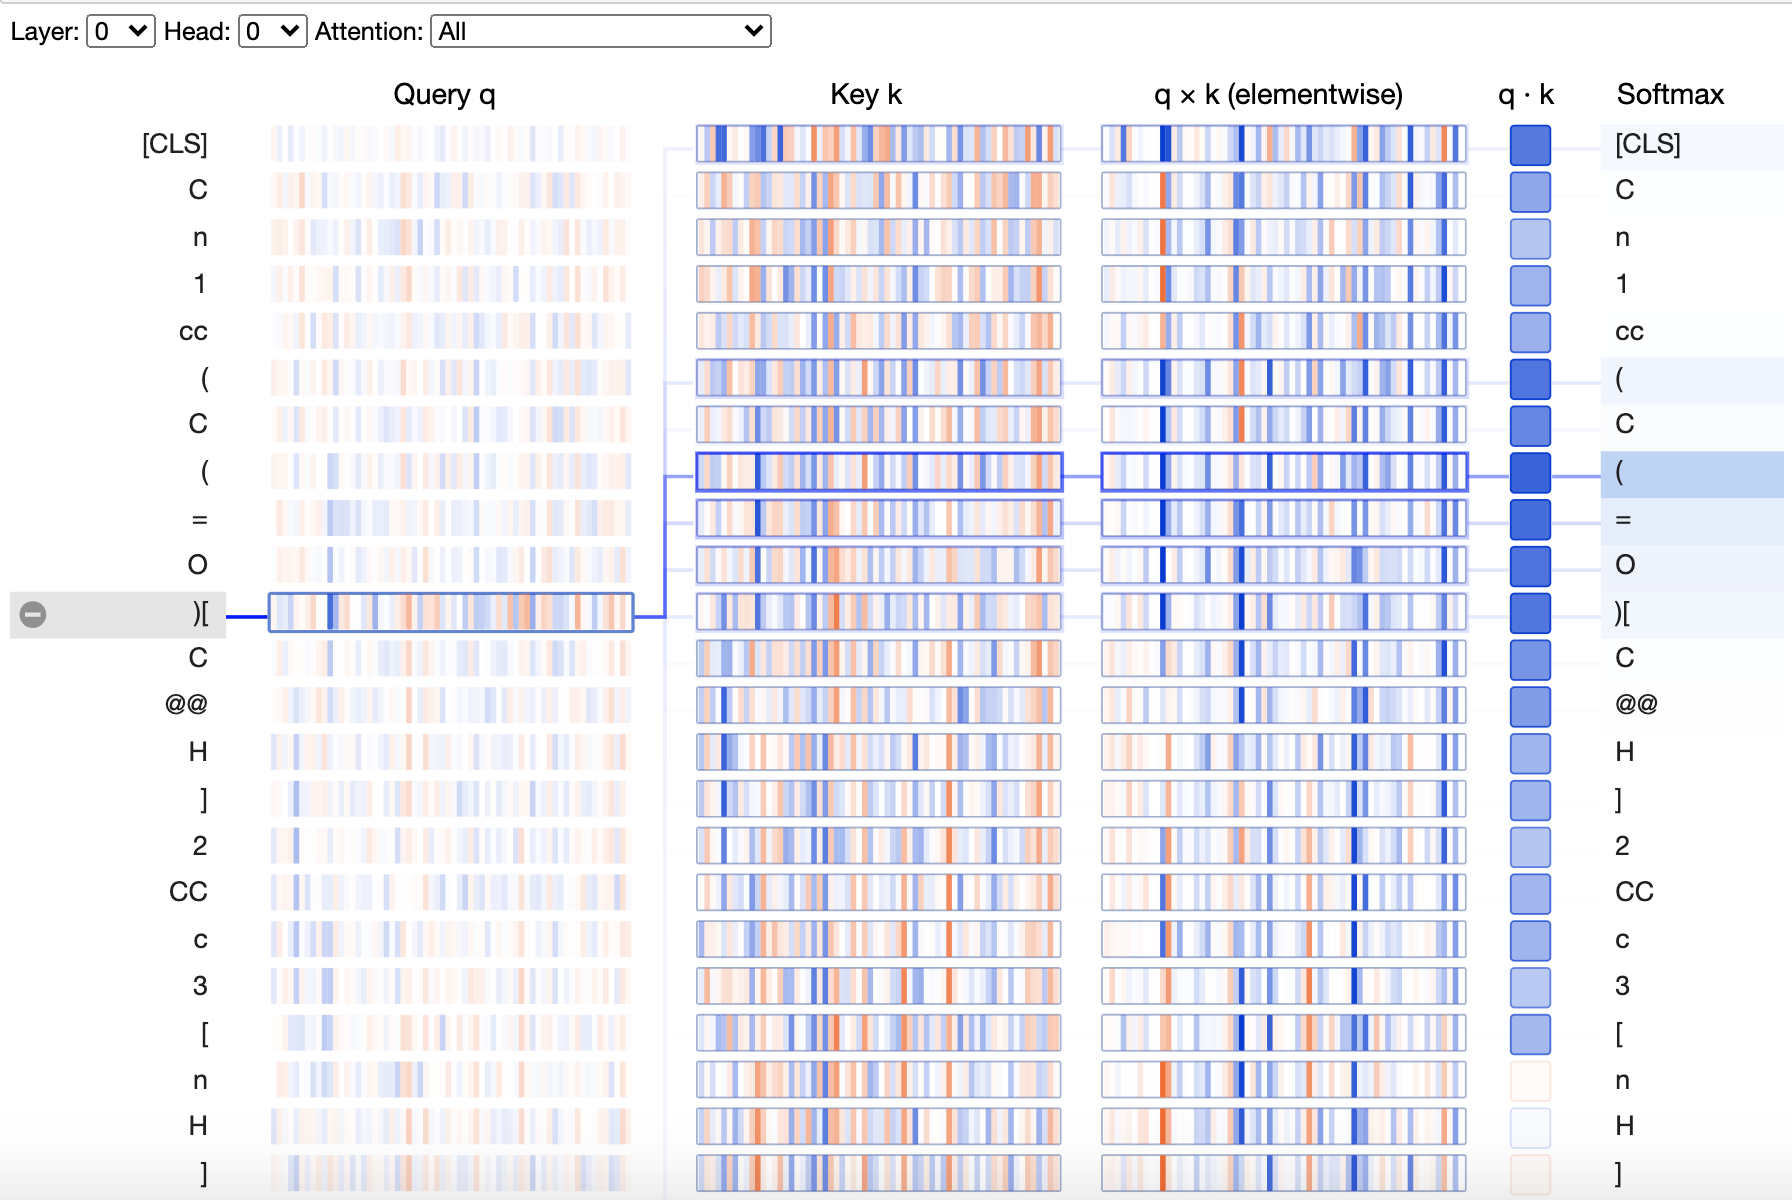

You can try out the ChemBERTa attention visualization demo's in more detail, with custom SMILES/SELFIEs strings, tokenizers, and more in the public library, [here](https://github.com/seyonechithrananda/bert-loves-chemistry).

# Fine-tuning ChemBERTa on a Small Mollecular Dataset

Our fine-tuning dataset, ClinTox, consists of qualitative data of drugs approved by the FDA and those that have failed clinical trials for toxicity reasons.

The ClinTox dataset consists of 1478 binary labels for toxicity, using the SMILES representations for identifying molecules. The computational models produced from the dataset could become decision-making tools for government agencies in determining which drugs are of the greatest potential concern to human health. Additionally, these models can act as drug screening tools in the drug discovery pipelines for toxicity.

Let's start by importing the MolNet dataloder from `bert-loves-chemistry`, before importing apex and transformers, the tool which will allow us to import the pre-trained masked-language modelling architecture trained on PubChem.

In [26]:
%cd /content/bert-loves-chemistry

/content/bert-loves-chemistry


In [27]:
!pwd

/content/bert-loves-chemistry


In [28]:
import os

import numpy as np
import pandas as pd

from typing import List

# import molnet loaders from deepchem
from deepchem.molnet import load_bbbp, load_clearance, load_clintox, load_delaney, load_hiv, load_qm7, load_tox21
from rdkit import Chem


# import MolNet dataloder from bert-loves-chemistry fork
from utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop


Lets use the MolNet dataloader to generate scaffold splits from the ClinTox dataset.

In [29]:
tasks, (train_df, valid_df, test_df), transformers = load_molnet_dataset("clintox", tasks_wanted=None)


INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.


Using tasks ['CT_TOX'] from available tasks for clintox: ['FDA_APPROVED', 'CT_TOX']


If you're only running the toxicity prediction portion of this tutorial, make sure you install transformers here. If you've ran all the cells before, you can ignore this install as we've already done `pip install transformers` before.

In [ ]:
!pip install transformers

In [30]:
train_df

,text,labels
0,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,0
1,O=C(NCC(O)CO)c1c(I)c(C(=O)NCC(O)CO)c(I)c(N(CCO...,1
2,Clc1cc(Cl)c(OCC#CI)cc1Cl,1
3,N#Cc1cc(NC(=O)C(=O)[O-])c(Cl)c(NC(=O)C(=O)[O-])c1,1
4,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,1
...,...,...
1177,CC(C[NH2+]C1CCCCC1)OC(=O)c1ccccc1,1
1178,CC(C(=O)[O-])c1ccc(C(=O)c2cccs2)cc1,1
1179,CC(c1cc2ccccc2s1)N(O)C(N)=O,1
1180,CC(O)C(CO)NC(=O)C1CSSCC(NC(=O)C([NH3+])Cc2cccc...,1


In [31]:
valid_df

,text,labels
0,CC(C)OC(=O)CCC/C=C\C[C@H]1[C@@H](O)C[C@@H](O)[...,1
1,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,1
2,CC(C)n1c(/C=C/[C@H](O)C[C@H](O)CC(=O)[O-])c(-c...,1
3,CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)[NH+]1CCCC1,1
4,CSCC[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)...,1
...,...,...
143,C[C@H](OC(=O)c1ccccc1)C1=CCC23OCC[NH+](C)CC12C...,1
144,C[C@@H](c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1F,1
145,CC(C)C[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H]...,1
146,C[C@H](O)[C@H](O)[C@H]1CNc2[nH]c(N)nc(=O)c2N1,1


In [32]:
test_df

,text,labels
0,C[NH+]1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4C...,1
1,C[C@]1(Cn2ccnn2)[C@H](C(=O)[O-])N2C(=O)C[C@H]2...,1
2,C[NH+]1CCC[C@@H]1CCO[C@](C)(c1ccccc1)c1ccc(Cl)cc1,1
3,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,1
4,OC[C@H]1O[C@@H](n2cnc3c2NC=[NH+]C[C@H]3O)C[C@@...,1
...,...,...
143,O=C1O[C@H]([C@@H](O)CO)C([O-])=C1O,1
144,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H]...,1
145,C#CC[NH2+][C@@H]1CCc2ccccc21,1
146,[H]/[NH+]=C(\N)c1ccc(OCCCCCOc2ccc(/C(N)=[NH+]/...,1


From here, lets set up a logger to record if any issues occur, and notify us if there are any problems with the arguments we've set for the model. 

In [33]:
from simpletransformers.classification import ClassificationModel
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


Now, using `simple-transformer`, let's load the pre-trained model from HuggingFace's useful model-hub. We'll set the number of epochs to 3 in the arguments, but you can train for longer. Also make sure that `auto_weights` is set to True to do automatic weight balancing, as we are dealing with imbalanced toxicity datasets. 

In [34]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model = ClassificationModel('roberta', 'seyonec/SMILES_tokenized_PubChem_shard00_160k', args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 10, 'auto_weights': True}) # You can set class weights by using the optional weight argument


Some weights of the model checkpoint at seyonec/SMILES_tokenized_PubChem_shard00_160k were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/SMILES_tokenized_PubChem_shard00_160k and are newly initialized: ['classi

In [35]:
print(model.tokenizer)

PreTrainedTokenizer(name_or_path='seyonec/SMILES_tokenized_PubChem_shard00_160k', vocab_size=591, model_max_len=514, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


Now, lets modify `ClassificationModel` such that it utilizes the DeepChem `SmilesTokenizer` to tokenize the ClinTox property prediction dataset:



In [38]:
model.tokenizer = SmilesTokenizer('/content/vocab.txt')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1423: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


Let's verify that the tokenizer was successfully modified.

In [40]:
print(model.tokenizer)

# check if our train and evaluation dataframes are setup properly. There should only be two columns for the SMILES string and its corresponding label.
print("Train Dataset: {}".format(train_df.shape))
print("Eval Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

PreTrainedTokenizer(name_or_path='', vocab_size=591, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
Train Dataset: (1182, 2)
Eval Dataset: (148, 2)
TEST Dataset: (148, 2)


Now that we've set everything up, lets get to the fun part: training the model! We use Weights and Biases, which is optional (simply remove `wandb_project` from the list of `args`). Its a really useful tool for monitering the model's training results (such as accuracy, learning rate and loss), alongside custom visualizations of attention and gradients. 

When you run this cell, Weights and Biases will ask for an account, which you can setup through a Github account, giving you an authorization API key which you can paste into the output of the cell. Again, this is completely optional and it can be removed from the list of arguments.

In [41]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Finally, the moment we've been waiting for! Let's train the model on the train scaffold set of ClinTox, and monitor our runs using W&B. We will evaluate the performance of our model each epoch using the validation set.

In [42]:
# Create directory to store model weights (change path accordingly to where you want!)
!mkdir SmilesTokenizer_PubChem_10M_ClinTox_run

# Train the model
model.train_model(train_df, eval_df=valid_df, output_dir='/content/BPE_PubChem_10M_ClinTox_run', args={'wandb_project': 'project-name'})


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


wandb: Currently logged in as: seyonec (use `wandb login --relogin` to force relogin)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to /content/BPE_PubChem_10M_ClinTox_run.


Let's install scikit-learn now, to evaluate the model we've trained.

In [43]:
import sklearn

# accuracy
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)

# ROC-PRC
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.average_precision_score)



INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


Training loss,0.0002
lr,0.0
global_step,1450
_step,28
_runtime,112
_timestamp,1606031407


Training loss,▁▂▁▂▂▁▇▂▁▁▁▁▁▁▁▂▁▂▅█▁▁▁▁▁▁▁▁▁
lr,▅██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_runtime,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███


INFO:simpletransformers.classification.classification_model:{'mcc': 0.4599649248754488, 'tp': 139, 'tn': 2, 'fp': 7, 'fn': 0, 'acc': 0.9527027027027027, 'eval_loss': 0.1978553198657066}
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


_step,2
_runtime,11
_timestamp,1606031425


_step,▁▅█
_runtime,▁▁█
_timestamp,▁▁█


INFO:simpletransformers.classification.classification_model:{'mcc': 0.4599649248754488, 'tp': 139, 'tn': 2, 'fp': 7, 'fn': 0, 'acc': 0.952054794520548, 'eval_loss': 0.1978553198657066}


The model performs pretty well, averaging above 95% ROC-PRC after training on only ~1400 data samples and 150 positive leads in a couple of minutes! This model was also trained on 1/10th the amount of pre-training data as the PubChem-10M BPE model we used previously, but it still showcases robust performance. We can clearly see the predictive power of transfer learning, and approaches like these are becoming increasing popular in the pharmaceutical industry where larger datasets are scarce. By training on more epochs and tasks, we can probably boost the accuracy as well!

Lets evaluate the model on one last string from ClinTox's test set for toxicity. The model should predict 1, meaning the drug failed clinical trials for toxicity reasons and wasn't approved by the FDA.

In [44]:
# Lets input a molecule with a toxicity value of 1
predictions, raw_outputs = model.predict(['C1=C(C(=O)NC(=O)N1)F'])


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [45]:
print(predictions)
print(raw_outputs)

[1]
[[-3.12890625  2.875     ]]


The model predicts the sample correctly! Some future tasks may include using the same model on multiple tasks (Tox21 provides multiple tasks relating to different biochemical pathways for toxicity, as an example), through multi-task classification, as well as training on a larger dataset such as HIV, one of the other harder tasks in molecular machine learning. This will be expanded on in future work! In the next tutorial, we'll be training a similar variant of ChemBERTa, that utilizes a different tokenizer, the [SmilesTokenizer](https://deepchem.readthedocs.io/en/latest/api_reference/tokenizers.html) which is built-in to DeepChem! Let see if using a tokenizer which splits SMILES sequences into syntatically relevant chemical tokens performs differently, especially on attention visualizaiton tasks!

#Congratulations! Time to join the Community!
Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

# **Star DeepChem on [Github](https://github.com/deepchem/deepchem)**
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

# **Join the DeepChem Gitter**
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!
